# Notebook 1: Creating Street Network
DO NOT TOUCH THIS NOTEBOOK OR ANY CELLS AGAIN UNLESS CHANGES NEED TO BE MADE.

OSMnx Documentation
https://onlinelibrary.wiley.com/doi/10.1111/gean.70009

# 1. Importing packages

In [1]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.cm as cm
import json
# Geopackages
import geopandas as gpd
import shapely
from shapely.geometry import Point
import osmnx as ox
import networkx as nx

In [2]:
# Setting global settings to change imported tags
ox.settings.useful_tags_way = ['highway', 'lanes', 'maxspeed', 'cycleway']

# 2. Importing OSMnx street network data - DO NOT RUN AGAIN

Steps: 
1. Import polygon for City of Waterloo
2. Expand borders from original city boundaries
3. Import street network from expanded polygon using ox.graph_from_polygon function

## 2.1 Step 1: Importing polygon from OSMnx

In [3]:
# Importing boundary
place_name = "Waterloo, Ontario, Canada"
a = ox.geocode_to_gdf(place_name)
# motorroads_byborder = ox.graph_from_place(place_name)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

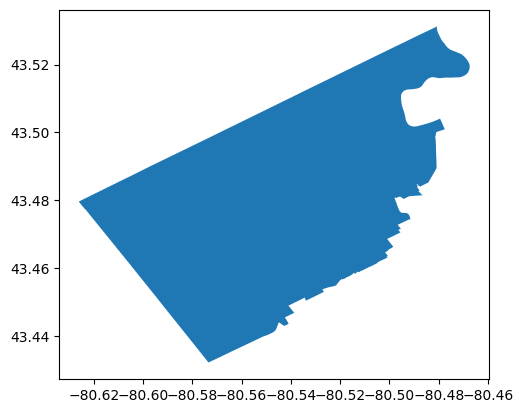

In [4]:
a.plot()
a.crs

## 2.2 Step 2: Creating buffer around original polygon

Area before buffering: 0    6.525521e+07
dtype: float64
Area after buffering: 0    1.517353e+08
dtype: float64


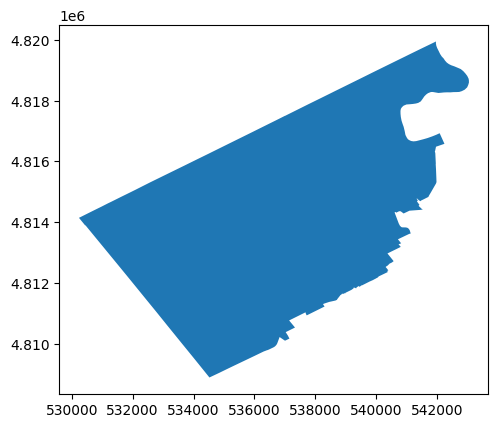

In [5]:
# Reprojecting to a projected CRS to buffer area
a = a.to_crs(32617)
a.plot()
print('Area before buffering:', a.area)

# Buffer
a.geometry = a.geometry.buffer(2000)
print('Area after buffering:', a.area)

## 2.3 Step 3: Importing street network with buffered polygon

https://geoffboeing.com/2016/11/osmnx-python-street-networks/

In [6]:
# Re-projecting buffered geometry to EPSG:4326 
a = a.to_crs(4326)
print(a.crs)

# Getting polygon from geodataframe 
a_polygon = a.geometry.iloc[0]
print('a_polygon type', type(a_polygon)) 

# Importing network
# network_type='bike' filters all areas where bicycle=yes (all ways where bikes can legally travel)
g = ox.graph_from_polygon(a_polygon, network_type='bike', truncate_by_edge=False)

# projecting graph:

EPSG:4326
a_polygon type <class 'shapely.geometry.polygon.Polygon'>


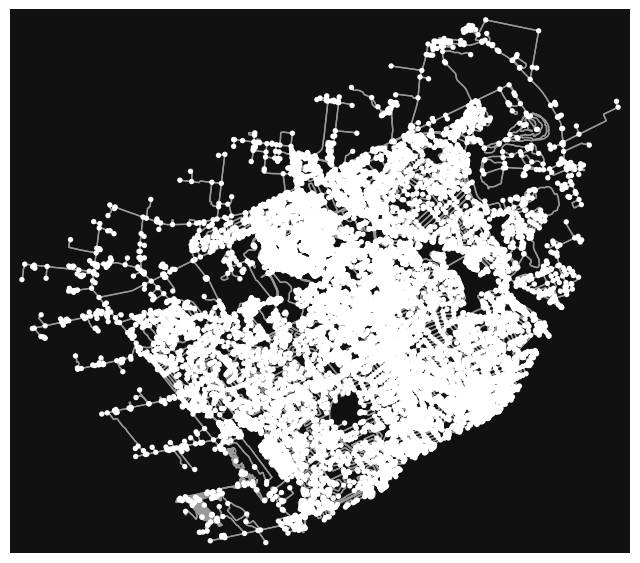

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
ox.plot_graph(g)

In [8]:
# net.edges(data='weight')

basic_stats = ox.basic_stats(g)

basic_stats

{'n': 20357,
 'm': 52600,
 'k_avg': 5.167755563196935,
 'edge_length_total': 3338139.28734889,
 'edge_length_avg': 63.46272409408537,
 'streets_per_node_avg': 2.5917866090288353,
 'streets_per_node_counts': {0: 0,
  1: 5335,
  2: 0,
  3: 12740,
  4: 2216,
  5: 56,
  6: 8,
  7: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2620720145404529,
  2: 0.0,
  3: 0.6258289531856364,
  4: 0.10885690425897726,
  5: 0.002750896497519281,
  6: 0.0003929852139313258,
  7: 9.824630348283146e-05},
 'intersection_count': 15022,
 'street_length_total': 1669069.6436744262,
 'street_segment_count': 26300,
 'street_length_avg': 63.46272409408465,
 'circuity_avg': 1.1393731960675022,
 'self_loop_proportion': 0.017224334600760456}

In [9]:
# for u, v, key, data in net.edges(keys=True, data=True):
#         # u is the origin node ID
#         # v is the destination node ID
#         # key is the unique identifier for parallel edges between u and v
#         # data is a dictionary containing the edge's attributes
#         print(f"Edge from {u} to {v} (key={key}), Attributes: {data}")

# 4. Plotting with connectivity values - DO NOT RUN AGAIN

https://geoffboeing.com/2018/01/urban-street-network-centrality/
<br>Betweenness Centrality Github: https://github.com/gboeing/osmnx-examples/blob/v0.11/notebooks/08-example-line-graph.ipynb

## 4.1 Computing node centrality

In [10]:
# Computing betweenness centrality for each node
node_centrality = nx.betweenness_centrality(g)

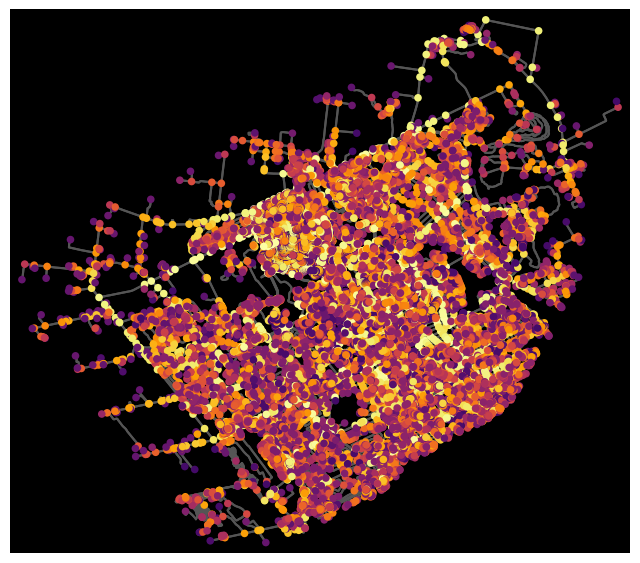

In [11]:
# Plotting node centrality
df = pd.DataFrame(data = pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df=df.reindex(g.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(g, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2, edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

## 4.1 Computing edge centrality

In [12]:
# Converting graph to line graph so edges become node and vice versa (see GB github)
edge_centrality = nx.betweenness_centrality(nx.line_graph(g))

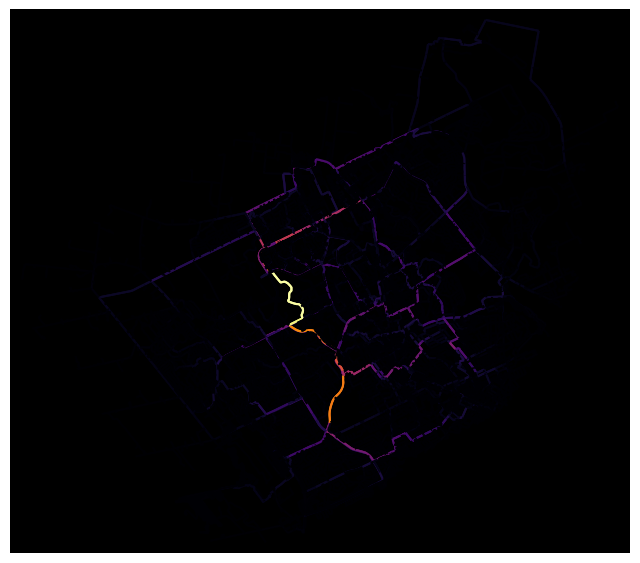

In [13]:
# list of edge values for the original graph
ev = [edge_centrality[edge] for edge in g.edges]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(g, bgcolor='k', node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

## 4.3 Converting network to gdf

In [14]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(
    g, nodes=True, edges=True,
    node_geometry=False, fill_edge_geometry=False)

# print geodataframe in notebook
gdf_edges.head()

osmid    highway lanes maxspeed  \
u        v         key                                                    
10782939 340086040 0                196461233  secondary     2       60   
         533769764 0                384921496  secondary     2       60   
         295175096 0                196461233  secondary     2       60   
         295175045 0    [38896609, 871538111]  secondary     2       60   
10782965 340086081 0                503446166  secondary     2       60   

                       cycleway  oneway reversed      length  \
u        v         key                                         
10782939 340086040 0       lane   False    False   11.415097   
         533769764 0        NaN   False     True   12.990882   
         295175096 0       lane   False     True  127.571201   
         295175045 0       lane   False    False  562.906997   
10782965 340086081 0        NaN   False    False   12.632849   

                                                                 geometry  
u        v         key                                                     
10782939 340086040 0                                                 None  
         533769764 0                                                 None  
         295175096 0    LINESTRING (-80.55813 43.47046, -80.55836 43.4...  
         295175045 0    LINESTRING (-80.55813 43.47046, -80.55797 43.4...  
10782965 340086081 0                                                 None

In [15]:
gdf_edges['cycleway'].value_counts()

cycleway
lane                    1842
no                      1528
crossing                 884
shared_lane              288
separate                 192
designated                20
[separate, crossing]      10
shared                     8
yes                        2
shoulder                   2
[shared_lane, lane]        1
[lane, shared_lane]        1
Name: count, dtype: int64

# 6. Data Export
<br>Note: Since the keys for edge centrality are tuples, they had to be converted to single strings for export to the JSON file. "|" separator was used between each integer when combining.

In [16]:
# # Exporting graph data
# gdf_nodes.to_file('Data/gdf_nodes.gpkg')
# gdf_edges.to_file('Data/gdf_edges.gpkg')

In [17]:
# Exporting graph data
gdf_nodes.to_csv('Data/gdf_nodes.csv')
gdf_edges.to_csv('Data/gdf_edges.csv')

In [18]:
# Exporting node_centrality
filename = 'Data/node_centrality.json'
data = node_centrality
with open(filename, 'w') as outfile:
    json.dump(data, outfile)

In [19]:
# Exporting node and edge centrality dictionaries

# Converting all edge centrality tuple keys to strings
for key in list(edge_centrality.keys()):
    new_key = str(key[0]) + '|' + str(key[1]) + '|' + str(key[2])
    edge_centrality[new_key] = edge_centrality[key]
    del edge_centrality[key]

# File export
filename = 'Data/edge_centrality.json'
data = edge_centrality
with open(filename, 'w') as outfile:
    json.dump(data, outfile)

In [20]:
gdf_edges.head(2)

osmid    highway lanes maxspeed cycleway  oneway  \
u        v         key                                                         
10782939 340086040 0    196461233  secondary     2       60     lane   False   
         533769764 0    384921496  secondary     2       60      NaN   False   

                       reversed     length geometry  
u        v         key                               
10782939 340086040 0      False  11.415097     None  
         533769764 0       True  12.990882     None

In [21]:
gdf_nodes.head(2)

,y,x,highway,street_count,junction
osmid,,,,,
10782939,43.470458,-80.558132,traffic_signals,4,NaN
10782965,43.483418,-80.565314,traffic_signals,4,NaN


In [22]:
ox.graph_from_gdfs(gdf_nodes, gdf_edges)